In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../Environment/")
import halite_env as Env
import encode as cod

In [2]:
from importlib import reload
#reload(Env)
reload(cod)

<module 'encode' from '/home/nicola/Nicola_unipd/QuartoAnno/TODO/Baiesi/RL/haliteRL/encode.py'>

In [3]:
#@@@@@@@@@@@@@@@@@@@
# RL agent functions
#@@@@@@@@@@@@@@@@@@@

def greedy_policy(s, q_values):
    return np.argmax(q_values[s])

def e_greedy_policy(s, q_values, eps = 0.01):
    # s is encoded in input, a is encoded in output
    u = np.random.rand()
    if u > eps:
        return np.argmax(q_values[s])
    else:
        return np.random.randint(0, len(q_values[s]))

    
def update_q_v0(s, a, r, sp, ap, q_values, gamma = 1):
    q_values[s,a] = r + gamma*q_values[sp,ap]
    return q_values

def update_q_v1(s, a, r, sp, ap, q_values, gamma = 1, n_cells = 49, h_lev = 3, n_actions = 5, alpha = 0.1):
    s_dec = cod.decode3D(s, L1 = n_cells, L2 = h_lev**6, L3 = n_actions-1)
    sp_dec = cod.decode3D(sp, L1 = n_cells, L2 = h_lev**6, L3 = n_actions-1)
    shipy_pos = (n_cells-1)/2 #shipyard is at the center of the map
    if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
        q_values[s,a] = (1-alpha)*q_values[s,a] + alpha*r # sp is terminal state -> enforce to have Q-value = 0 for all actions ap
        #print("Terminal value update rule executed.")
    else:
        q_values[s,a] = (1-alpha)*q_values[s,a] + alpha*(r + gamma*q_values[sp,ap]) # normal update
    return q_values

In [32]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
NUM_PLAYERS = 1
MAP_SIZE = 7 # 7 x 7 map
TOT_TURNS = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
H_LEV = 3 # halite levels
N_CELLS = MAP_SIZE**2 # number of cells in a square map
N_STATES = N_CELLS*H_LEV**6*4
N_ACTIONS = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", N_STATES)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
N_BATCH = 10 #100 # number of episodes in an epoch
MAX_EPOCHS = 200 # max number of epochs played before stopping (500 ~ 7.3 hours of training)
DISCOUNT_FACTOR = 1 - 1/TOT_TURNS #train ships as if each turn has a probability of 1/tot_turns of ending the game 
STD_REWARD = -0.01
LEARNING_RATE = 0.1

Total number of states to be experienced:  142884


<IPython.core.display.Javascript object>


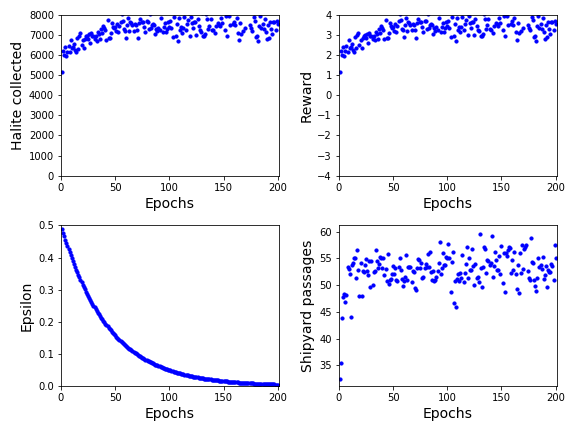

Hey, I think you've had enough! Let's stop here.


<IPython.core.display.Javascript object>


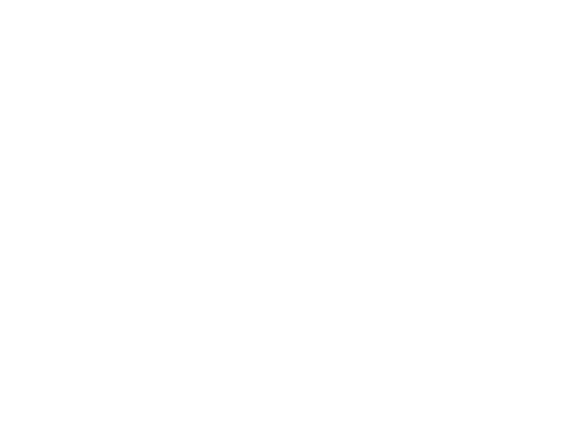

In [33]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained
reward_score = np.zeros(MAX_EPOCHS)
halite_score = np.zeros(MAX_EPOCHS)
shipy_pass = np.zeros(MAX_EPOCHS)
epochs = 0

# visualize online the results
%matplotlib notebook
fig = plt.figure(figsize = (8,6))
plt.ion()

ax1 = fig.add_subplot(221)
ax1.set_xlim(0,MAX_EPOCHS+1)
ax1.set_ylim(0,8000)
ax1.set_xlabel("Epochs", fontsize = 14)
ax1.set_ylabel("Halite collected", fontsize = 14)

ax2 = fig.add_subplot(222)
ax2.set_xlim(0,MAX_EPOCHS+1)
ax2.set_ylim(-4,4)
ax2.set_xlabel("Epochs", fontsize = 14)
ax2.set_ylabel("Reward", fontsize = 14)


ax3 = fig.add_subplot(223)
ax3.set_xlim(0,MAX_EPOCHS+1)
ax3.set_ylim(0,0.5)
ax3.set_xlabel("Epochs", fontsize = 14)
ax3.set_ylabel("Epsilon", fontsize = 14)


ax4 = fig.add_subplot(224)
ax4.set_xlim(0,MAX_EPOCHS+1)
ax4.set_xlabel("Epochs", fontsize = 14)
ax4.set_ylabel("Shipyard passages", fontsize = 14)

plt.tight_layout()
fig.show()
fig.canvas.draw()

from tqdm import tnrange

for k in tnrange(MAX_EPOCHS):
    #@@@@@@@@@@@@@@@@@@@@@@
    # here starts an epoch
    #@@@@@@@@@@@@@@@@@@@@@@
    epochs = epochs + 1
    reward_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    halite_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    shipy_pass_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    eps = 0.5 # starting value of epsilon
    # generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
    epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))
    
    for i in range(N_BATCH):
        #@@@@@@@@@@@@@@@@@@@@@@@@
        # here starts an episode
        #@@@@@@@@@@@@@@@@@@@@@@@@
        env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = TOT_TURNS) # init environment
        steps = 0
        reward = 0 # cumulative reward of the episode
        passages = 0 # number of times the ship passes through the shipyard
        
        # first mandatory step
        steps = steps + 1
        #print("\nStep number %d:"%steps)
        action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
        shipyard_action = 1 # initially always choose to create a ship
        # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
        state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
        #print("Cargo layer: \n", state[:,:,2])
        current_halite = players_halite[0][0]
        #s_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
        s8_enc = cod.sym_encode(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False) 
        
        while True:
            steps = steps + 1
            #print("\nStep number %d:"%steps)
            #print("Current halite: ", current_halite)
            a_enc = e_greedy_policy(s8_enc[0], q_values, eps = epsilons[epochs])
            a8_enc = cod.sym_action(a_enc) # returns the 8 symmetric actions for the 8 symmetric states
            #print("Actions (8 symmetric) decided: ", a8_enc)
            # use only the action decided in the original state to interact with the environment
            a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE)
            #print("Interact with the environment...")
            # submit the action and get the new state
            state, players_halite, finish, _ = env.step(a_mat, makeship = False) 
            #print("Cargo layer: \n", state[:,:,2])
            new_halite = players_halite[0][0]
            #print("New halite: ", new_halite)
            # compute the 1--ship reward as the halite increment of the player divided by the max halite 
            # plus a standard negative reward 
            r = (new_halite - current_halite)/1000 + STD_REWARD
            #print("Reward obtained: ", r)
            sp8_enc = cod.sym_encode(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
            #print("New encoded states (8 symmetric): \n",sp8_enc)
            reward = reward + r # cumulative reward of the episode, obsolete
            
            # counts the passages through the shipyard
            s_dec = cod.decode3D(s8_enc[0], L1 = N_CELLS, L2 = H_LEV**6, L3 = N_ACTIONS-1)
            sp_dec = cod.decode3D(sp8_enc[0], L1 = N_CELLS, L2 = H_LEV**6, L3 = N_ACTIONS-1)
            shipy_pos = (N_CELLS-1)/2 #shipyard is at the center of the map
            if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
                passages = passages +1            

            # simulate the best action in the new state (before update)
            a_temp_enc = e_greedy_policy(sp8_enc[0], q_values, eps = epsilons[epochs])
            a8_temp_enc = cod.sym_action(a_temp_enc)
            
            for x in range(8):
                # update Q-values
                q_values = update_q_v1(s8_enc[x], a8_enc[x], r, sp8_enc[x], a8_temp_enc[x], q_values, gamma = DISCOUNT_FACTOR, 
                                    n_cells = N_CELLS, h_lev = H_LEV, n_actions = N_ACTIONS, alpha = LEARNING_RATE)
            # update states and halite
            s8_enc = sp8_enc
            current_halite = new_halite
            
            if (finish == True) or (steps >= 400):
                #print("End episode.")
                reward_progress[i] = reward
                halite_progress[i] = current_halite - 4000
                shipy_pass_progress[i] = passages
                break
        #break # play just 1 episode
                
    #break # play just 1 epoch
    
    """print("Average reward per episode in epoch %d: %.3f"%(epochs, reward_progress.mean()))
    print("Average halite collected per episode in epoch %d: %.3f"%(epochs,halite_progress.mean()))
    print("Espilon value: %.4f \n"%epsilons[epochs])"""
    reward_score[epochs-1] = reward_progress.mean()
    halite_score[epochs-1] = halite_progress.mean()
    shipy_pass[epochs-1] = shipy_pass_progress.mean()
    
    ax1.scatter(epochs, halite_score[epochs-1], s = 10, color='blue')
    ax2.scatter(epochs, reward_score[epochs-1], s = 10,color='blue')
    ax3.scatter(epochs, epsilons[epochs], s = 10, color='blue')
    ax4.scatter(epochs, shipy_pass[epochs-1], s = 10, color='blue')
    fig.canvas.draw()
    
    if epochs >= MAX_EPOCHS:
        print("Hey, I think you've had enough! Let's stop here.")
        break

In [34]:
np.save("Q_values_sym", q_values)
#q_values = np.load("Q_values.npy")